Plotting 10000 complete-lifecycle clouds out of 10000 total clouds


/var/folders/s9/348b6n453lb4f4t0zsmgd28m0000gn/T/ipykernel_75843/2963351928.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Set2', active_num_clouds)


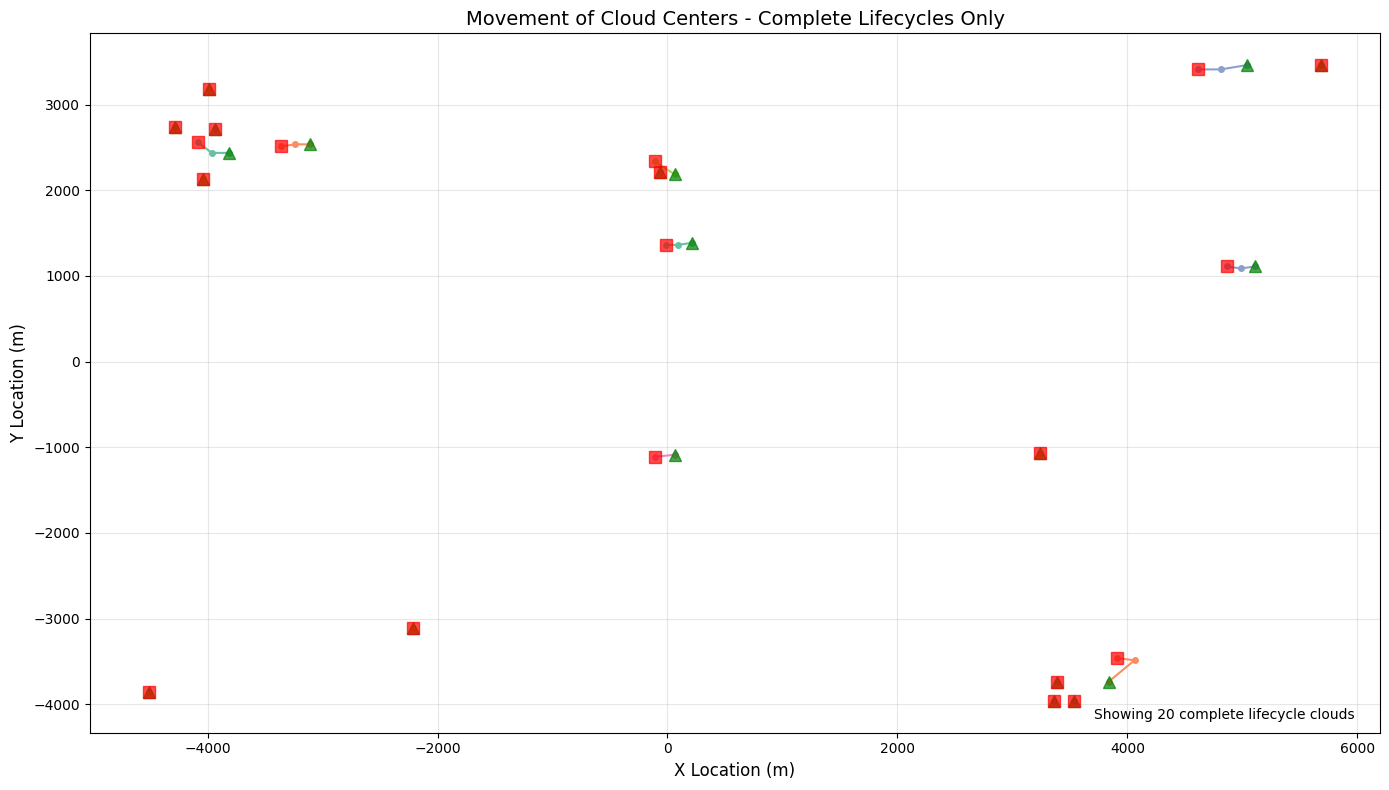

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import matplotlib.cm as cm

nc_file = '../cloud_results.nc'  # Replace this with your actual NetCDF file path
dataset = Dataset(nc_file, 'r')

# Load valid_track to identify complete lifecycle clouds
valid_tracks = dataset.variables['valid_track'][:]  # 1 = complete lifecycle, 0 = partial lifecycle
full_lifecycle_mask = (valid_tracks == 1)
print(f"Plotting {np.sum(full_lifecycle_mask)} complete-lifecycle clouds out of {len(valid_tracks)} total clouds")

# Reading cloud center locations
x_centers = dataset.variables['location_x'][:]  
y_centers = dataset.variables['location_y'][:]

# Filter for clouds that have both valid data and complete lifecycles
valid_cloud_indices = (np.any(~np.isnan(x_centers), axis=1) & 
                        np.any(~np.isnan(y_centers), axis=1) & 
                        full_lifecycle_mask)
active_num_clouds = np.sum(valid_cloud_indices)  # Number of valid, full-lifecycle clouds

# Generate a color map for the active clouds
colors = cm.get_cmap('Set2', active_num_clouds)

# Plot for cloud center movements
plt.figure(figsize=(14, 8))
color_idx = 0  # To index into the colors array

for cloud_idx in range(len(valid_cloud_indices)):
    if valid_cloud_indices[cloud_idx]:  # Check if the cloud has valid data and is full lifecycle
        valid_idx = ~np.isnan(x_centers[cloud_idx, :]) & ~np.isnan(y_centers[cloud_idx, :])
        if np.any(valid_idx):  # Ensure there are valid points to plot
            # Find cloud track duration to label it
            track_duration = np.sum(valid_idx)
            
            # Plot the track with a label showing cloud ID and duration
            plt.plot(x_centers[cloud_idx, valid_idx], y_centers[cloud_idx, valid_idx], '-o', 
                    color=colors(color_idx), linewidth=1.5, markersize=4,
                    label=f'Cloud {cloud_idx+1} ({track_duration} steps)')
            
            # Optionally add start/end markers
            plt.plot(x_centers[cloud_idx, valid_idx][0], y_centers[cloud_idx, valid_idx][0], 'g^', 
                    markersize=8, alpha=0.7)  # Green triangle for start
            plt.plot(x_centers[cloud_idx, valid_idx][-1], y_centers[cloud_idx, valid_idx][-1], 'rs', 
                    markersize=8, alpha=0.7)  # Red square for end
            
            color_idx += 1  # Move to the next color for the next active cloud

plt.xlabel('X Location (m)', fontsize=12)
plt.ylabel('Y Location (m)', fontsize=12)
plt.title('Movement of Cloud Centers - Complete Lifecycles Only', fontsize=14)
plt.grid(True, alpha=0.3)

# Only show legend if there aren't too many clouds to keep it readable
if active_num_clouds <= 15:
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=10)
else:
    plt.text(0.98, 0.02, f"Showing {active_num_clouds} complete lifecycle clouds", 
             horizontalalignment='right', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

dataset.close()

Analyzing 10000 complete-lifecycle clouds...


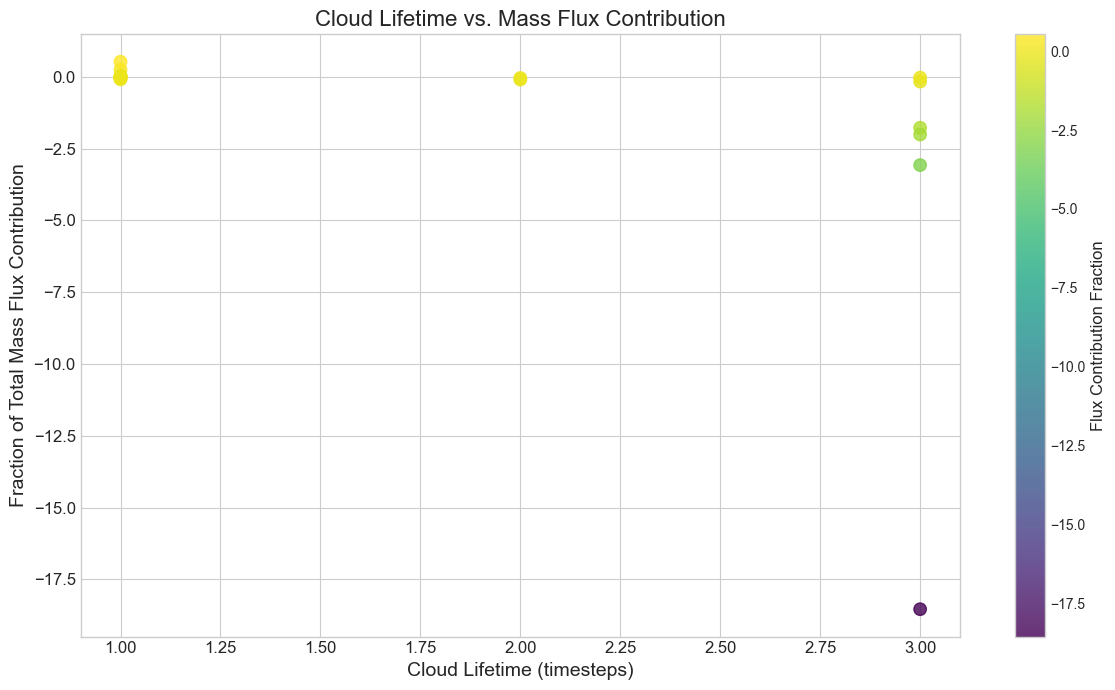

In [2]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

# --- 1. Data Loading and Preparation ---
nc_file = '../cloud_results.nc'
try:
    dataset = Dataset(nc_file, 'r')

    # Load necessary variables from the NetCDF file
    valid_tracks = dataset.variables['valid_track'][:]
    cloud_mass_flux_per_level = dataset.variables['mass_flux_per_level'][:]
    env_mass_flux_per_level = dataset.variables['env_mass_flux_per_level'][:]
    # Use location_x to determine active timesteps for each cloud
    location_x = dataset.variables['location_x'][:]
    
    # --- 2. Calculate Total Domain Flux per Timestep ---
    # Sum mass flux from all clouds for each timestep and level
    total_cloud_flux_per_level_time = np.nansum(cloud_mass_flux_per_level, axis=0)
    # Sum environment mass flux for each timestep and level
    total_env_flux_per_level_time = env_mass_flux_per_level
    
    # Combine cloud and environment flux, then sum over levels to get total flux per timestep
    total_domain_flux_per_timestep = np.nansum(total_cloud_flux_per_level_time + total_env_flux_per_level_time, axis=1)

    # --- 3. Analyze Each Complete Lifecycle Cloud ---
    full_lifecycle_indices = np.where(valid_tracks == 1)[0]
    
    cloud_lifetimes = []
    flux_contributions = []

    print(f"Analyzing {len(full_lifecycle_indices)} complete-lifecycle clouds...")

    for cloud_idx in full_lifecycle_indices:
        # Determine the active timesteps for this cloud
        active_timesteps_mask = ~np.isnan(location_x[cloud_idx, :])
        
        if not np.any(active_timesteps_mask):
            continue

        # Calculate the cloud's lifetime
        lifetime = np.sum(active_timesteps_mask)
        cloud_lifetimes.append(lifetime)

        # Numerator: Sum of this cloud's mass flux over its entire lifecycle (all levels and active times)
        cloud_total_flux = np.nansum(cloud_mass_flux_per_level[cloud_idx, active_timesteps_mask, :])
        
        # Denominator: Sum of the total domain's mass flux during this cloud's active period
        domain_total_flux_during_lifetime = np.nansum(total_domain_flux_per_timestep[active_timesteps_mask])
        
        # Calculate the contribution fraction
        if domain_total_flux_during_lifetime == 0:
            contribution = 0
        else:
            contribution = cloud_total_flux / domain_total_flux_during_lifetime
        
        flux_contributions.append(contribution)

    # --- 4. Plotting the Results ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    
    scatter = plt.scatter(cloud_lifetimes, flux_contributions, 
                          c=flux_contributions, cmap='viridis', alpha=0.8, s=80)
    
    plt.xlabel('Cloud Lifetime (timesteps)', fontsize=14)
    plt.ylabel('Fraction of Total Mass Flux Contribution', fontsize=14)
    plt.title('Cloud Lifetime vs. Mass Flux Contribution', fontsize=16)
    
    # Add a colorbar to show the magnitude of contribution
    cbar = plt.colorbar(scatter)
    cbar.set_label('Flux Contribution Fraction', fontsize=12)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

finally:
    if 'dataset' in locals():
        dataset.close()

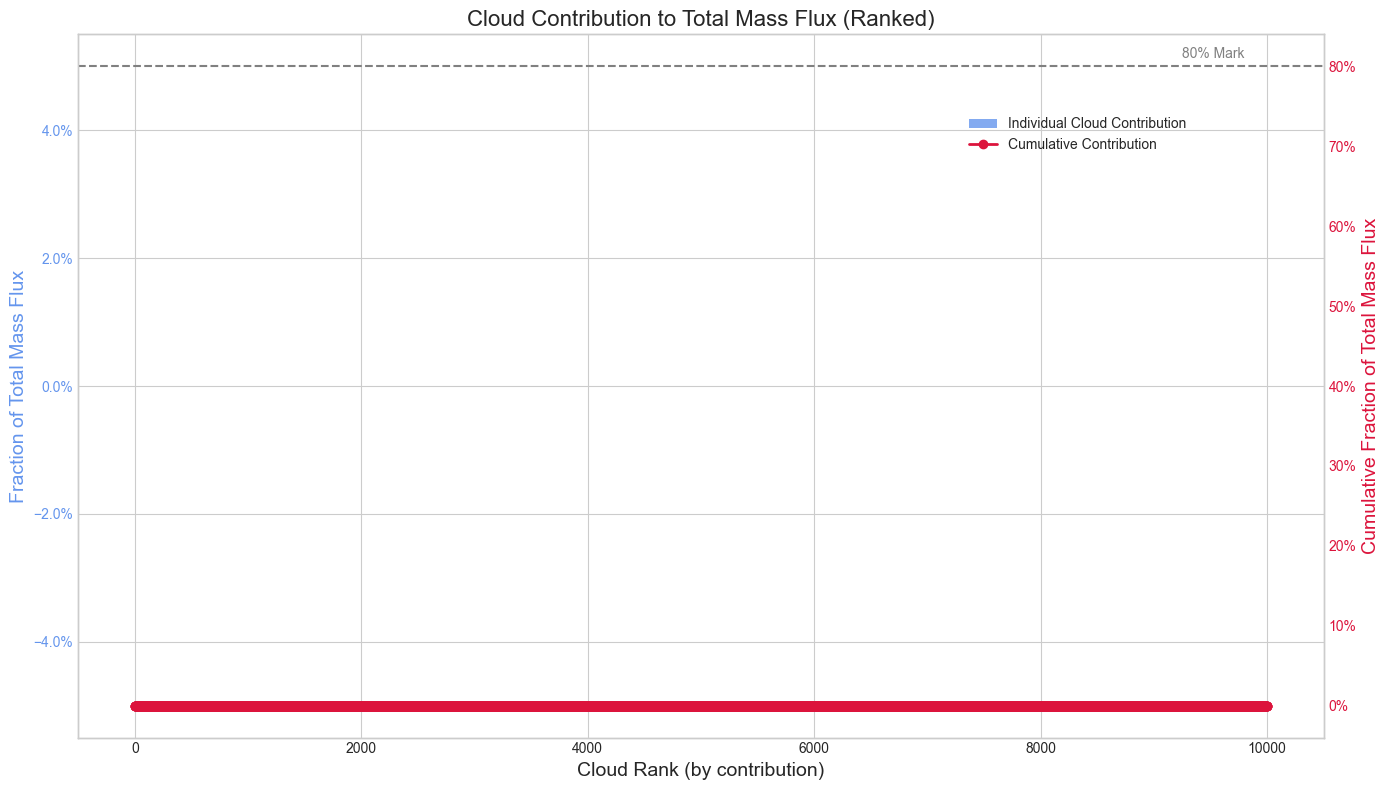

In [3]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import matplotlib.ticker as mticker

# --- 1. Data Loading and Preparation ---
nc_file = '../cloud_results.nc'
try:
    dataset = Dataset(nc_file, 'r')

    # Load necessary variables
    valid_tracks = dataset.variables['valid_track'][:]
    cloud_mass_flux_per_level = dataset.variables['mass_flux_per_level'][:]
    env_mass_flux_per_level = dataset.variables['env_mass_flux_per_level'][:]
    
    # --- 2. Calculate Total Fluxes ---
    # Denominator: Total domain mass flux over the entire simulation period
    total_cloud_flux = np.nansum(cloud_mass_flux_per_level)
    total_env_flux = np.nansum(env_mass_flux_per_level)
    total_domain_flux = total_cloud_flux + total_env_flux

    # --- 3. Calculate and Rank Individual Cloud Contributions ---
    full_lifecycle_indices = np.where(valid_tracks == 1)[0]
    
    contributions = []
    for cloud_idx in full_lifecycle_indices:
        # Numerator: Sum of this cloud's mass flux over its entire lifecycle
        cloud_total_flux = np.nansum(cloud_mass_flux_per_level[cloud_idx, :, :])
        
        # Calculate contribution as a fraction of the total domain flux
        if total_domain_flux > 0:
            contribution = cloud_total_flux / total_domain_flux
        else:
            contribution = 0
        contributions.append(contribution)
    
    # Sort contributions in descending order
    sorted_contributions = np.sort(contributions)[::-1]
    
    # Calculate cumulative contributions
    cumulative_contributions = np.cumsum(sorted_contributions)

    # --- 4. Plotting the Rank-Contribution Chart ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    num_clouds = len(sorted_contributions)
    cloud_ranks = np.arange(1, num_clouds + 1)
    
    # Bar plot for individual contributions
    ax1.bar(cloud_ranks, sorted_contributions, color='cornflowerblue', alpha=0.8, label='Individual Cloud Contribution')
    ax1.set_xlabel('Cloud Rank (by contribution)', fontsize=14)
    ax1.set_ylabel('Fraction of Total Mass Flux', fontsize=14, color='cornflowerblue')
    ax1.tick_params(axis='y', labelcolor='cornflowerblue')
    ax1.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    
    # Line plot for cumulative contributions on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(cloud_ranks, cumulative_contributions, color='crimson', marker='o', linestyle='-', linewidth=2, label='Cumulative Contribution')
    ax2.set_ylabel('Cumulative Fraction of Total Mass Flux', fontsize=14, color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    ax2.grid(False) # Turn off grid for the secondary axis
    
    # Add a horizontal line for the 80% mark (Pareto principle)
    ax2.axhline(y=0.8, color='grey', linestyle='--', linewidth=1.5)
    ax2.text(num_clouds * 0.98, 0.81, '80% Mark', color='grey', ha='right')

    plt.title('Cloud Contribution to Total Mass Flux (Ranked)', fontsize=16)
    fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9), bbox_transform=ax1.transAxes)
    plt.tight_layout()
    plt.show()

finally:
    if 'dataset' in locals():
        dataset.close()